In [1]:
import matplotlib.pyplot as plt
import torch
import h5py

In [17]:
import os
import mrpro

/opt/conda/envs/RecoEnv311/lib/python3.11/site-packages/torch/__config__.py:9: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969073/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._show_config()


In [2]:
%matplotlib widget

In [8]:
raw_path = "/home/global/mri_datasets/fastmri/brain_multicoil_train"
csm_path = "/echo/_allgemein/projects/Open Source MRI/Data/csm_reconstructed/brain_multicoil_train"

In [9]:
def get_raw(filename):
    return torch.Tensor(h5py.File(os.path.join(raw_path, filename))["reconstruction_rss"][:])

In [10]:
def get_proc(filename):
    return torch.Tensor(h5py.File(os.path.join(csm_path, filename))["reconstruction_smap"][:])

In [18]:
def proc_gpu(dataset_file, smooth_width=1):
    # reading the k-space data
    k_space_raw = torch.tensor(dataset_file["kspace"][:])
    # mrmpro.walsh expects data to be (coils, z, height (y), width (x))
    # since the slices are not lie on each other (not real z dimension)
    # we observe the slices individually
    # this results the shape of (slices, coils, 1, height, width)
    k_space = torch.unsqueeze(k_space_raw, 2)
    k_space = k_space.to(device="cuda")
    image_space = torch.fft.ifftshift(
        torch.fft.ifftn(
        torch.fft.fftshift(k_space, dim=(-1, -2)), dim=(-1, -2)), dim=(-1, -2))
    # evaluate for each slice in slices
    sl_list = [mrpro.algorithms.csm.walsh(sl, smooth_width) for sl in torch.unbind(image_space, 0)]
    # sensitivity maps for each slices (slices, coils, 1, height, width)
    sens_maps = torch.stack(sl_list, dim=0)
    # see mrpro.operators.SensitivityOp
    # applying the sensitivity maps to the image_space images
    # sum over coils and "1" dimension to obtain the normalized images
    # of shape (slices, height, width)
    return torch.sum(sens_maps.conj()*image_space, dim=(1,2)).to(device="cpu")

/opt/conda/envs/RecoEnv311/lib/python3.11/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

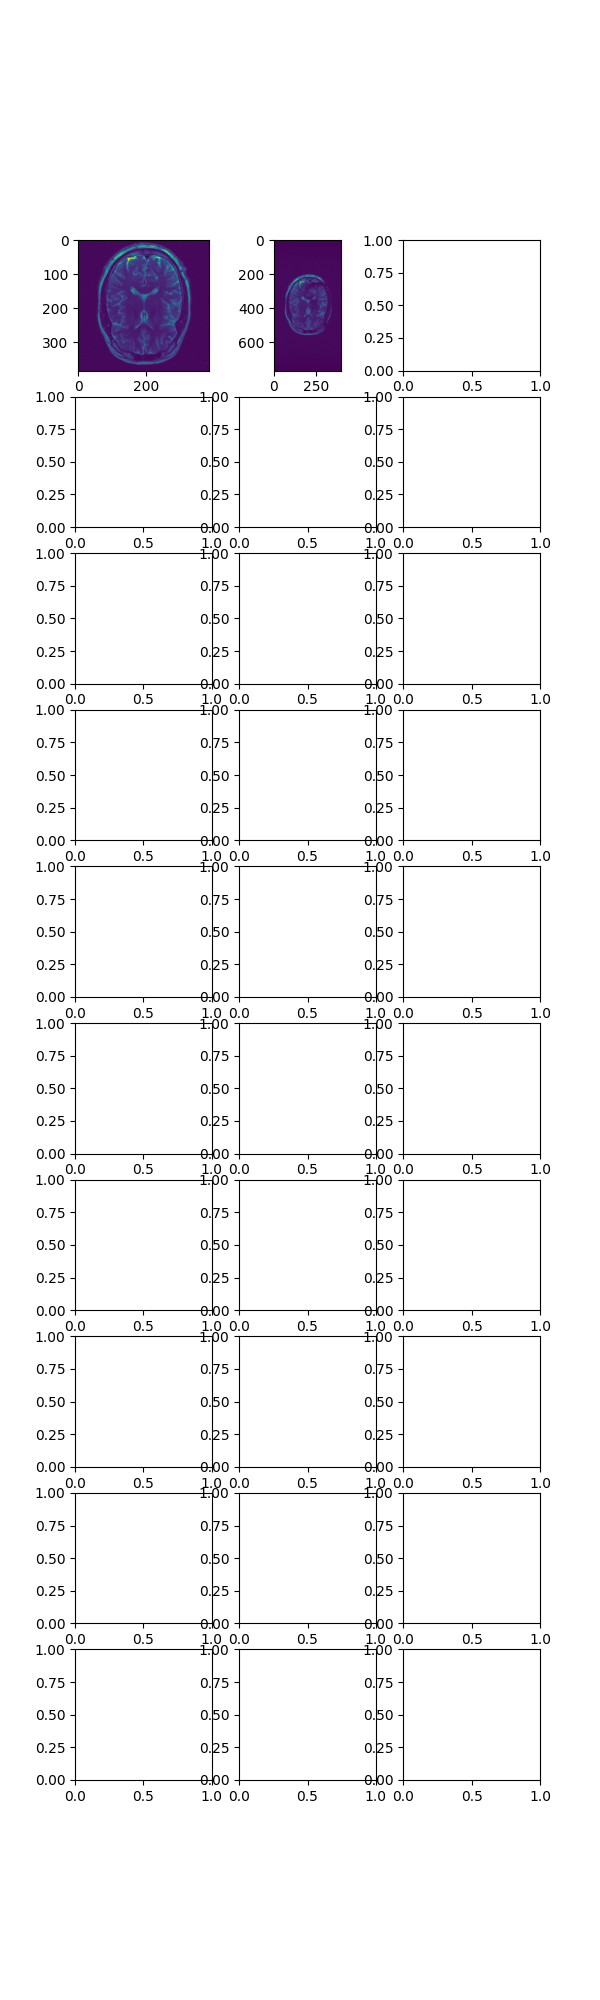

In [19]:
f = plt.figure(figsize=(6, 20))
ax = f.subplots(10,3)
for i, file in enumerate(os.listdir(csm_path)):
    head, filename = os.path.split(file)
    raw, proc = get_raw(filename)[2], get_proc(filename)[2]
    ax[i][0].imshow(raw.abs())
    ax[i][1].imshow(proc.abs())
    evaluated = proc_gpu(h5py.File(os.path.join(raw_path, filename)))
    ax[i][2].imshow(evaluated[2].abs())